# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.attention import SelfAttMFii
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = SelfAttMFii(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

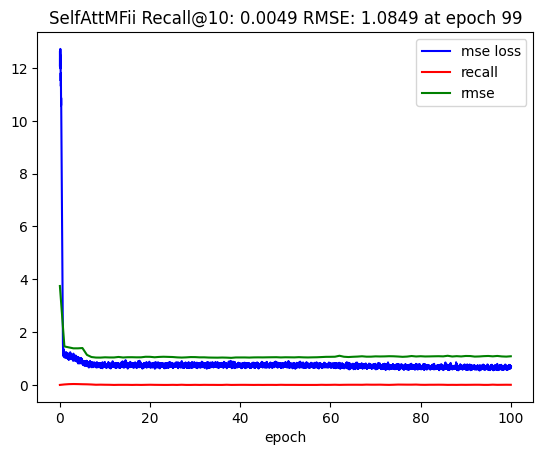

SelfAttMFii Recall@10: 0.0049 RMSE: 1.0849 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'SelfAttMFii Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'SelfAttMFii Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

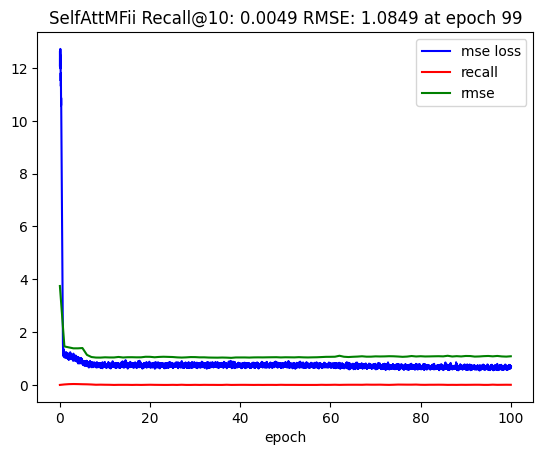

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'SelfAttMFii Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [8]:
recall_list

[0.0,
 0.018032786885245903,
 0.029508196721311476,
 0.03442622950819672,
 0.03114754098360656,
 0.02622950819672131,
 0.022950819672131147,
 0.01639344262295082,
 0.006557377049180328,
 0.009836065573770493,
 0.006557377049180328,
 0.004918032786885246,
 0.0,
 0.003278688524590164,
 0.003278688524590164,
 0.003278688524590164,
 0.0,
 0.003278688524590164,
 0.0,
 0.003278688524590164,
 0.006557377049180328,
 0.003278688524590164,
 0.001639344262295082,
 0.0,
 0.0,
 0.003278688524590164,
 0.0,
 0.006557377049180328,
 0.0,
 0.0,
 0.003278688524590164,
 0.0,
 0.003278688524590164,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.006557377049180328,
 0.0,
 0.001639344262295082,
 0.003278688524590164,
 0.003278688524590164,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.004918032786885246,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.004918032786885246,
 0.0

In [9]:
rmse_list

[3.7455985624060464,
 1.4571286084576383,
 1.4203906013661238,
 1.3850569102579577,
 1.3853433584833255,
 1.3961197383705302,
 1.1376998704810788,
 1.0561018890730949,
 1.0362930677273918,
 1.0345049842688587,
 1.0454500093663233,
 1.0397486321490041,
 1.0398619595028789,
 1.0587980629236353,
 1.0390534364692228,
 1.0483305192878285,
 1.0490185442213595,
 1.0447037228469482,
 1.0453175588807542,
 1.0660656395540706,
 1.0639915095327537,
 1.0471121675948898,
 1.060189427508128,
 1.0666344367065497,
 1.0613338016811693,
 1.0563388471085324,
 1.0432021204997084,
 1.036416089652316,
 1.0429979527417697,
 1.0542447326362123,
 1.052753512008632,
 1.043788002373092,
 1.0445526896910622,
 1.036489585264726,
 1.0341757106974707,
 1.032435342828587,
 1.037143225395816,
 1.0327754442547592,
 1.0251411643166166,
 1.0394714239173424,
 1.0398224654337231,
 1.0402037011156797,
 1.0355685006973394,
 1.0418197646485352,
 1.0436834965151707,
 1.0420819344880423,
 1.045145513542418,
 1.047369142884967,
 

In [10]:
# max(recall_list), min(rmse_list) 
print(f'SelfAttMFii Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'SelfAttMFii Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

SelfAttMFii Max Recall@10: 0.0344 at epoch 3
SelfAttMFii Min RMSE: 1.0251 at epoch 38
